In [1]:
import numpy as np
import pandas as pd
import os, shutil, json
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import keras.callbacks as cbks
from numpy import argmax
from PIL import Image
from pathlib import Path
from statistics import mean 
from functools import partial
from keras import backend as K
from keras.utils import np_utils
from keras.regularizers import l1, l2
from keras.models import Sequential, Model
from keras.layers.merge import _Merge
from keras.optimizers import RMSprop, Adam, SGD
from keras.preprocessing import image
from keras.engine.topology import Layer
from keras.utils.np_utils import to_categorical
from keras.initializers import truncated_normal, glorot_normal
from keras.losses import categorical_crossentropy, binary_crossentropy, mean_squared_error, mean_squared_logarithmic_error
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras_contrib.layers.advanced_activations.swish import Swish
from keras.preprocessing.image import img_to_array, ImageDataGenerator
from keras import layers, models, regularizers, backend, utils
from keras.layers import Activation, BatchNormalization, Conv2D, Conv2DTranspose, Dense, Dropout, Flatten, initializers, InputSpec, Input, LeakyReLU, MaxPooling2D, Reshape
from sklearn.model_selection import train_test_split

abs_path = r'%s' % os.getcwd().replace('\\','/')

C:\Users\Pichau\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Pichau\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Pichau\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Pichau\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: P

In [2]:
Imagens_DataFrame = pd.read_csv("./1_imagens_Mckinsey666.csv") 
Imagens_DataFrame.head()

,path,width,height,size
0,0_2000.jpg,63,63,63 63
1,10000_2004.jpg,62,62,62 62
2,10001_2004.jpg,79,79,79 79
3,10002_2004.jpg,51,51,51 51
4,10003_2004.jpg,77,77,77 77


In [3]:
Imagens_DataFrame.groupby('size').count().sort_values('path').tail()

,path,width,height
size,,,
90 90,1516,1516,1516
95 95,1530,1530,1530
94 94,1534,1534,1534
96 96,1556,1556,1556
92 92,1636,1636,1636


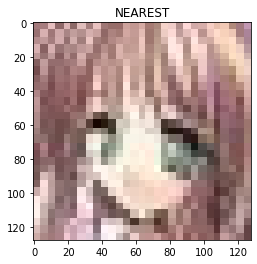

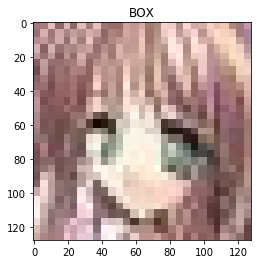

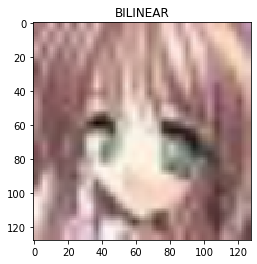

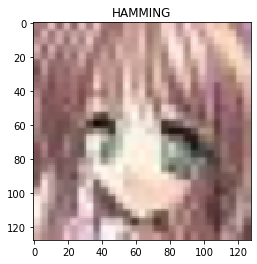

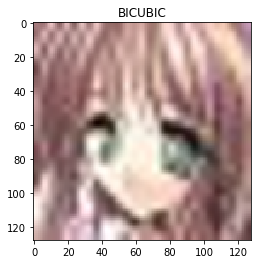

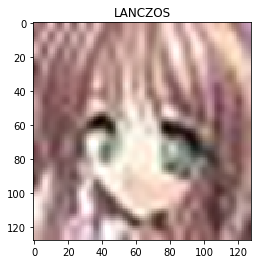

In [4]:
#rede = rede()
#rede.build_network()
im = Image.open("./1_Mckinsey666/7_2000.jpg")
ims = []
size = (128,128)
ims.append(im.resize(size,Image.NEAREST))
ims.append(im.resize(size,Image.BOX))
ims.append(im.resize(size,Image.BILINEAR))
ims.append(im.resize(size,Image.HAMMING))
ims.append(im.resize(size,Image.BICUBIC))
ims.append(im.resize(size,Image.LANCZOS))

plt.subplot(111)
plt.title("NEAREST")
plt.imshow(ims[0])
plt.show()
plt.subplot(111)
plt.title("BOX")
plt.imshow(ims[1])
plt.show()
plt.subplot(111)
plt.title("BILINEAR")
plt.imshow(ims[2])
plt.show()
plt.subplot(111)
plt.title("HAMMING")
plt.imshow(ims[3])
plt.show()
plt.subplot(111)
plt.title("BICUBIC")
plt.imshow(ims[4])
plt.show()
plt.subplot(111)
plt.title("LANCZOS")
plt.imshow(ims[5])
plt.show()

# Modelo Genérica

In [5]:
class RandomWeightedAverage(_Merge):
    def _merge_function(self, inputs):
        weights = K.random_uniform((32, 1, 1, 1))
        return (weights * inputs[0]) + ((1 - weights) * inputs[1])

In [6]:
class rede:
    def __init__(self, batch_size = 20, images_size = 64):
        self.generator_input = 100
        self.latent_dim = 32
        self.height = images_size
        self.width = images_size
        self.channels = 3
        self.iterations = 100
        self.batch_size = batch_size
        self.NPZ_file_path = os.path.join(abs_path, "2_imagens_Mckinsey666_"+str(self.height)+"_"+str(self.height)+".npz").replace('\\','/')
        self.create_numpy_file()
        self.my_ReduceLROnPlateau_losses = []
        self.my_ReduceLROnPlateau_sentinela = 0
        self.generator = []
        self.discriminator = []
        self.gan = []
        
        images_path = os.path.join(abs_path,'2_Generated_Images_' + str(self.height) + '_' + str(self.height) + '_WGAN').replace('\\','/')
        if not os.path.exists(images_path):
            os.mkdir(images_path)
        self.save_dir = images_path
        
    def create_numpy_file(self):
        imagens_x = []
        if not os.path.exists(self.NPZ_file_path):
            Imagens_DataFrame = pd.read_csv("./1_imagens_Mckinsey666.csv")
            for index, row in Imagens_DataFrame.iterrows():
                    image_path = os.path.join(abs_path, '1_Mckinsey666', row['path']).replace('\\','/')
                    image = Image.open(image_path)
                    newsize = (self.height, self.width)
                    image = image.resize(newsize, Image.LANCZOS) 
                    image_numpy = np.asarray(image)
                    imagens_x.append(image_numpy)

            imagens_x = np.asarray(imagens_x, dtype=np.float32)
            np.savez(self.NPZ_file_path, x=imagens_x)
    
    def get_images_as_nparray(self):
        with np.load(self.NPZ_file_path) as data:
            imagens_x = data['x']
        #x_train = imagens_x.reshape((imagens_x.shape[0],) + (self.height, self.width, self.channels)).astype('float32') / 255.
        x_train = (imagens_x.reshape((imagens_x.shape[0],) + (self.height, self.width, self.channels)).astype('float32') - 127.5 ) / 127.5
        #x_train = (imagens_x.reshape((imagens_x.shape[0],) + (self.height, self.width, self.channels)).astype('float32') / 127.5 ) - 0.5
        return x_train
        
    def create_generator(self):
        generator_input = keras.Input(shape=(self.generator_input,))
        
        x = Dense(128 * int(self.height/2) * int(self.width/2))(generator_input)
        x = LeakyReLU()(x)
        x = Reshape((int(self.height/2), int(self.width/2), 128))(x)

        x = Conv2D(256, 5, padding='same')(x)
        x = LeakyReLU()(x)

        x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
        x = LeakyReLU()(x)
        x = Conv2D(256, 5, padding='same')(x)
        x = LeakyReLU()(x)
        x = Conv2D(256, 5, padding='same')(x)
        x = LeakyReLU()(x)

        #Produces a 32 × 32 1-channel feature map (shape of a CIFAR10 image)
        x = Conv2D(self.channels, 7, activation='tanh', padding='same')(x)
        #Instantiates the generator model, which maps the input of shape (latent_dim,) into an image of shape (32, 32, 3)
        model = keras.models.Model(generator_input, x)
        
        return model
        
    
    def create_discriminator(self):
        discriminator_input = Input(shape=(self.height, self.width, self.channels))
        x = Conv2D(128, 3)(discriminator_input)
        x = LeakyReLU()(x)

        x = Conv2D(128, 4, strides=2)(x)
        x = LeakyReLU()(x)

        x = Conv2D(128, 4, strides=2)(x)
        x = LeakyReLU()(x)

        x = Conv2D(128, 4, strides=2)(x)
        x = LeakyReLU()(x)

        x = Flatten()(x)
        x = Dropout(0.4)(x)
        x = Dense(1, activation='sigmoid')(x)
        model = keras.models.Model(discriminator_input, x)

        discriminator_optimizer = keras.optimizers.RMSprop(
                lr=0.0008,
                clipvalue=1.0, #Uses gradient clipping (by value) in the optimizer
                decay=1e-8) #To stabilize training, uses learning-rate decay
        #model.compile(optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9), loss='binary_crossentropy')
        #model.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')
        return model
    
    def create_adversarial_net(self, x_train):
        discriminator = self.create_discriminator()
        generator = self.create_generator()
        
        #Generator model
        for layer in discriminator.layers:
            layer.trainable = False
        discriminator.trainable = False
        generator_input = Input(shape=(self.generator_input,))
        generator_layers = generator(generator_input)
        discriminator_layers_for_generator = discriminator(generator_layers)
        generator_model = Model(inputs=[generator_input],
                                outputs=[discriminator_layers_for_generator])
        generator_model.compile(optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9),
                                loss=self.wasserstein_loss)
        
        for layer in discriminator.layers:
            layer.trainable = True
        for layer in generator.layers:
            layer.trainable = False
        discriminator.trainable = True
        generator.trainable = False
        
        #Discriminator model
        GRADIENT_PENALTY_WEIGHT = 10
        real_samples = Input(shape=x_train.shape[1:])
        generator_input_for_discriminator = Input(shape=(self.generator_input,))
        generated_samples_for_discriminator = generator(generator_input_for_discriminator)
        discriminator_output_from_generator = discriminator(generated_samples_for_discriminator)
        discriminator_output_from_real_samples = discriminator(real_samples)
        averaged_samples = RandomWeightedAverage()([real_samples,
                                            generated_samples_for_discriminator])
        averaged_samples_out = discriminator(averaged_samples)
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          averaged_samples=averaged_samples,
                          gradient_penalty_weight=GRADIENT_PENALTY_WEIGHT)
        partial_gp_loss.__name__ = 'gradient_penalty'
        discriminator_model = Model(inputs=[real_samples,
                                    generator_input_for_discriminator],
                            outputs=[discriminator_output_from_real_samples,
                                     discriminator_output_from_generator,
                                     averaged_samples_out])
        discriminator_model.compile(optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9),
                            loss=[self.wasserstein_loss,
                                  self.wasserstein_loss,
                                  partial_gp_loss])
        
        return [discriminator_model, generator_model, generator]

    def my_ReduceLROnPlateau_loss(self, new_loss, step_of_iterations, factor = 0.5, patience = 10, epsilon = 1e-04, cooldown = 0, min_lr=0):
        #Se a lista estiver cheia, remove o primeiro elemento
        if len(self.my_ReduceLROnPlateau_losses) == patience:
            self.my_ReduceLROnPlateau_losses.pop(0)
            
        #Se for lista, existirá dois valores dentro, então  obtém só o primeiro
        if type(new_loss) is list:
            new_loss = new_loss[0]
        self.my_ReduceLROnPlateau_losses.append(new_loss)
        
        valor_antigo = float(K.get_value(self.discriminator.optimizer.lr))
        #Checa se a lista de pesos está cheia, a quantas iterações foi a última alteração
        if len(self.my_ReduceLROnPlateau_losses) == 10 and (step_of_iterations - self.my_ReduceLROnPlateau_sentinela) > cooldown and valor_antigo > min_lr:
            valor_min = mean(self.my_ReduceLROnPlateau_losses) - epsilon
            valor_max = mean(self.my_ReduceLROnPlateau_losses) + epsilon
            #verifica se houve alterações nos "Losses" nas últimas "patience" épocas
            validacao = [ (loss < valor_min or loss > valor_max) for loss in self.my_ReduceLROnPlateau_losses]
            if False in validacao: 
                valor_novo = valor_antigo * factor
                K.set_value(self.discriminator.optimizer.lr, valor_novo)
                print("[CALLBACK] Learning Rate atualizado na época {} de {} para {}".format(step_of_iterations, valor_antigo, valor_novo))
                #Se houver uma alteração, esprar "cooldown" rodadas para fazer uma nova alteração
                self.my_ReduceLROnPlateau_sentinela = step_of_iterations
                
    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)
    
    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples,
                          gradient_penalty_weight):
        gradients = K.gradients(y_pred, averaged_samples)[0]
        gradients_sqr = K.square(gradients)
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        gradient_penalty = gradient_penalty_weight * K.square(1 - gradient_l2_norm)
        return K.mean(gradient_penalty)
    
    def generate_images(self, generator_model, epoch):
        """Feeds random seeds into the generator and tiles and saves the output to a PNG
        file."""
        test_image_stack = generator_model.predict(np.random.rand(10, 100))
        test_image_stack = (test_image_stack * 127.5) + 127.5
        test_image_stack = np.squeeze(np.round(test_image_stack).astype(np.uint8))
        #tiled_output = tile_images(test_image_stack)
        tiled_output = Image.fromarray(test_image_stack, mode='RGB')  # L specifies greyscale
        outfile = os.path.join(self.save_dir, 'epoch_{}.png'.format(epoch))
        tiled_output.save(outfile)
    
    def build_network(self):
        start = 0
        x_train = self.get_images_as_nparray()
        discriminator_model, generator_model, generator = self.create_adversarial_net(x_train)
        
        TRAINING_RATIO = 5
        positive_y = np.ones((self.batch_size, 1), dtype=np.float32)
        negative_y = -positive_y
        dummy_y = np.zeros((self.batch_size, 1), dtype=np.float32)
                
        print("Chegou aqui")
        for epoch in range(self.iterations):
            np.random.shuffle(x_train)
            print("Epoch: ", epoch)
            print("Number of batches: ", int(x_train.shape[0] // self.batch_size))
            discriminator_loss = []
            generator_loss = []
            minibatches_size = self.batch_size * TRAINING_RATIO
            for i in range(int(x_train.shape[0] // (self.batch_size * TRAINING_RATIO))):
                discriminator_minibatches = x_train[i * minibatches_size:
                                                    (i + 1) * minibatches_size]
                for j in range(TRAINING_RATIO):
                    image_batch = discriminator_minibatches[j * self.batch_size:
                                                            (j + 1) * self.batch_size]
                    noise = np.random.rand(self.batch_size, self.generator_input).astype(np.float32)
                    discriminator_loss.append(discriminator_model.train_on_batch(
                        [image_batch, noise],
                        [positive_y, negative_y, dummy_y]))
                generator_loss.append(generator_model.train_on_batch(np.random.rand(self.batch_size, self.generator_input), positive_y))
            self.generate_images(generator, epoch)
        
        
        '''
        for step in range(self.iterations):            
            #TREINAR O DISCRIMINATOR
            random_latent_vectors = np.random.normal(size=(self.batch_size, self.generator_input))
            generated_images = self.generator.predict(random_latent_vectors)
            stop = start + self.batch_size
            real_images = x_train[start: stop]
            combined_images = np.concatenate([generated_images, real_images])
            labels = np.concatenate([np.zeros((self.batch_size, 1), dtype=np.float32), np.ones((self.batch_size, 1), dtype=np.float32)])
            #labels = np.concatenate([-np.ones((self.batch_size, 1)), np.ones((self.batch_size, 1))])
            #Adds random noise to the labels—an important trick!
            labels += 0.05 * np.random.random(labels.shape)
            d_loss = self.discriminator.train_on_batch(combined_images, labels)
            
            #TREINAR O GENERATOR
            random_latent_vectors = np.random.normal(size=(self.batch_size, self.generator_input))
            misleading_targets = np.ones((self.batch_size, 1), dtype=np.float32)
            a_loss = self.gan.train_on_batch(random_latent_vectors, misleading_targets)
            
            #CALLBACKS
            self.my_ReduceLROnPlateau_loss(d_loss, step, patience=15, cooldown = 15)
            
            start += self.batch_size
            if start > len(x_train) - self.batch_size:
                start = 0

            if step % 100 == 0 or step == self.iterations-1:
                #Saves model weights
                self.gan.save_weights("2_GAN_model_gan_"+str(self.height)+"_"+str(self.height)+".h5")
                #Prints metrics
                print('{} - discriminator loss: {} - adversarial loss: {}'.format(step, d_loss, a_loss))
                #Saves one generated image
                #img = image.array_to_img(generated_images[0] * 255., scale=False)
                img = image.array_to_img(np.squeeze(np.round((generated_images[0] * 127.5) + 127.5).astype(np.uint8)), scale=False)
                #img = image.array_to_img((generated_images[0] * 127.5) + 127.5, scale=False)
                img.save(os.path.join(self.save_dir,'2_GAN_' + str(step) + '_generated_anime.png'))
                #Saves one real image for comparison
                #img = image.array_to_img(real_images[0] * 255., scale=False)
                img = image.array_to_img(np.squeeze(np.round((real_images[0] * 127.5) + 127.5).astype(np.uint8)), scale=False)
                #img = image.array_to_img((real_images[0] * 127.5) + 127.5, scale=False)
                img.save(os.path.join(self.save_dir,'2_GAN_' + str(step) + '_real_anime.png'))
        '''

In [7]:
rede_32 = rede(32, 64)
rede_32.build_network()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Chegou aqui
Epoch:  0
Number of batches:  1986
Instructions for updating:
Use tf.cast instead.


C:\Users\Pichau\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


ValueError: Too many dimensions: 4 > 3.

In [ ]:
def test():
    print("OI")
test()